# 필요한 라이브러리 설치 및 Import

In [1]:
# python 표준 라이브러리
import os
import time
import glob # 쉘이 사용하는 규칙에 따라, 지정된 패턴과 일치하는 모든 경로명을 찾는 라이브러리

# 오픈소스 라이브러리
import tensorflow as tf
from tensorflow.keras import layers
import imageio
import matplotlib.pyplot as plt
import numpy as np
import PIL # Pillow, 파이썬 이미지 처리 라이브러리

# Colab Notebook Library
from IPython import display # 쉘의 출력을 제어할 수 있는 모듈

# 데이터셋 준비

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
# train image 0~255까지의 값을 갖는 int type 픽셀
print(train_images.shape)
print(train_labels.shape)

(60000, 28, 28)
(60000,)


In [7]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = train_images / 127.5 - 1 # 이미지를 [-1, 1]로 정규화

In [8]:
train_images.shape

(60000, 28, 28, 1)

In [23]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

# 데이터 배치를 만들고 섞는다
# from_tensor_slices 함수로 반환되는 BatchDataset 타입 데이터는 shuffle 메서드로 매 epochs에서 데이터를 섞어주고,
# 지정된 batch size만큼 자동으로 분할하여 반복 가능한 객체를 만들어줌
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 모델 구성

In [24]:
def make_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(128, activation = 'relu', input_shape=(100,))) # Latent vector 100 입력값
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(28*28*1, activation = 'tanh'))  # tanh 사용하여 뉴런의 값을 -1, 1 사이로 확정
    model.add(layers.Reshape((28, 28, 1)))
    return model

In [25]:
def make_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Flatten()) # 28 * 28을 1차원 벡터로 flatten
    model.add(layers.Dense(512, activation = 'relu'))
    model.add(layers.Dense(256, activation = 'relu'))
    model.add(layers.Dense(1))
    return model

In [26]:
generator = make_generator()
discriminator = make_discriminator()

In [46]:
generator.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 128)                 │          12,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 784)                 │         402,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 28, 28, 1)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 579,728 (2.21 MB)

 Trainable params: 579,728 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
discriminator.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (256, 784)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (256, 512)                  │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (256, 256)                  │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (256, 1)                    │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

# Loss Function 및 Optimizer 정의

In [27]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.

# binary Cross Entorpy (이진 크로스 엔트로피)
# 이진 분류 문제에 특화된 손실 함수
# - ( y * log(p) + (1-y) * log(1-p) )
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [28]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [29]:
# tf.ones_like는 입력값 shape와 동일하고 값이 모두 1

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [30]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# 훈련 과정 정의

In [38]:
EPOCHS = 50 # 시간 위해 50으로 설정, 원래 300~500이 적절
noise_dim = 100 # Generator의 input으로 사용 될 잠재 벡터의 크기
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다.
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [39]:
# `tf.function`이 어떻게 사용되는지 주목해 주세요.
# 이 데코레이터는 함수를 "컴파일"합니다.

@tf.function # tensorflow graph를 만들어, loss 기록, 가중치 기록 및 업데이트 등을 가능하게 함

def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # generator에 쓰일 noise 생성, (256, 100)

    # GradientTape: context 안에서 실행된 모든 연산을 tape에 기록,
    # 텐서플로는 후진 방식 자동 미분(reverse mode differentiation)을 사용해 테이프에 기록된 연산의 그래디언트를 계산
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # 오차역전파(backpropagation) - weight 업데이트
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [40]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [41]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다.
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

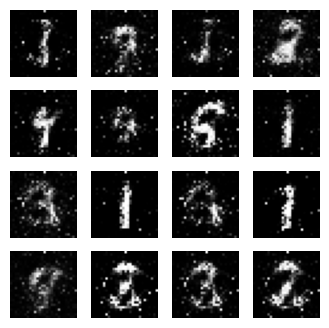

CPU times: user 20min 24s, sys: 25.8 s, total: 20min 49s
Wall time: 13min 5s


In [42]:
%%time
train(train_dataset, EPOCHS)

In [43]:
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

<ipython-input-43-767a4c587277>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-43-767a4c587277>:15: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


In [44]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download(anim_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>